In [383]:
# importing libaries
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import pandas as pd
import math as math
import datetime as time

In [384]:
#read data 
data = pd.read_csv('Almeria_Airp_-hour.dat',delimiter='\t')
data = data[1:].astype(float)
data.Ta +=273.15 #convert to Kelvin
data = pd.read_csv('Almeria_Airp_-hour3.dat')
data['date_time'] = pd.to_datetime({'year':2022,'month':data.m,'day':data.dm,'hour':data.h})
data.Ta +=273.15
#data.Az += math.pi/2            #corrects for orientation from east to west
data.describe()
data.m


0        1
1        1
2        1
3        1
4        1
        ..
8755    12
8756    12
8757    12
8758    12
8759    12
Name: m, Length: 8760, dtype: int64

In [385]:
''' What data do i have and what does it mean
    dofm: day of month
    dofy: day of the year
    hi: hour of the day
    Ta: temperature of air
    G_Gh: 
    Td: dew point temperature
    RH: relative himidity (%)
    G_DH: 
    FF: wind speed (m/s)
    DD: wind direction
    Lin: longwave radiation from the atmosphere
    RR: preciptation
    Sd: effective sunshine duration
    N: cloud cover
    hs: solar altitude
    TL: 
    G_Bn: 
    G_Gc: 
    GEX: Extraterrestrial radiation
    G_Ghmod: 
    PAR: Photosynthetically active radiation
    Snd: 
    Lup: Longwave (thermal, infrared) radiation on horizontal surface emitted from the earth's surface (longwave 
        outgoing) wavelength > 3 µm
'''
data.describe()

,y,m,dm,h,G_Gh,G_Dh,Ta,G_Lup,G_Bh,FF,...,hs,G_Lv,Az,DD,dy,hy,G_Gn2,Tsky,G_Gn1,date_time
count,8760.0,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,...,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760
mean,2005.0,6.526027,15.720548,12.500000,208.565068,75.487215,291.770297,414.843950,133.077511,3.919840,...,16.254760,387.007877,-15.814429,193.427968,183.000000,4380.500000,326.579338,4.750011,269.429338,2022-07-02 12:30:00
min,2005.0,1.000000,1.000000,1.000000,0.000000,0.000000,278.050000,325.000000,0.000000,0.000000,...,0.000000,305.000000,-176.300000,0.000000,1.000000,1.000000,-2.000000,-13.100000,0.000000,2022-01-01 01:00:00
25%,2005.0,4.000000,8.000000,6.750000,0.000000,0.000000,287.150000,380.000000,0.000000,2.100000,...,0.000000,359.000000,-101.100000,121.000000,92.000000,2190.750000,0.000000,-0.400000,0.000000,2022-04-02 06:45:00
50%,2005.0,7.000000,16.000000,12.500000,3.000000,3.000000,291.350000,410.000000,0.000000,3.500000,...,0.500000,384.000000,-27.300000,190.000000,183.000000,4380.500000,0.000000,4.800000,4.000000,2022-07-02 12:30:00
75%,2005.0,10.000000,23.000000,18.250000,406.000000,130.000000,296.150000,442.000000,241.000000,5.300000,...,30.225000,413.000000,79.500000,286.000000,274.000000,6570.250000,751.000000,9.700000,597.000000,2022-10-01 18:15:00
max,2005.0,12.000000,31.000000,24.000000,1021.000000,477.000000,311.150000,588.000000,904.000000,15.100000,...,76.000000,509.000000,154.500000,360.000000,365.000000,8760.000000,1173.000000,23.300000,1075.000000,2023-01-01 00:00:00
std,0.0,3.448048,8.796749,6.922582,282.384777,103.250245,5.994397,45.025139,200.553007,2.390256,...,21.364171,35.585887,98.874553,100.811352,105.372043,2528.938512,395.084098,6.315058,346.556594,NaN


In [386]:
# defining setup choices
time_int = 3600
t_span = np.array((data.dy*24+data.h-24)*time_int)
t_start = 24*6*30+5*24
t_span = t_span[t_start:t_start+240]
t0 = [0]
y0 = [data.Ta[t_start]]
#y0 = [273.15+13]
p = [1, 1]
Temp_cap_low = True                     # True if we want to set a value that can not be exceeded
Temp_cap_high = True
T_cap = 35+273.15
T_cap_low = 15+273.15
dilution_rate = 0 #V_reactor*0.0833/3600                 # random suggestion
harvest_hours = [12,13,14,15,16,17]                       # the hours when broth can be harvested
int_method = 'LSODA'                                        # what integration method is used
case = 'Round'                                               # with options Flat, Round, Multiple/else
T_in = 273.15+13                        # arbitrary inlet temperature fresh medium
glass_thickness = 2.2*10**-3 
L = 1                               # an arbitraty length of a meter of reactor is used
R_reactor = (65*(10**-3)-2*glass_thickness)/2           # according to manufacurer
V_reactor = L*math.pi*R_reactor**2      # reactor volume in m^3 
aeration_rate = 1*V_reactor/3600       #arbitrary aeration rate in volume/time unit  
y0

[np.float64(294.65)]

In [387]:
# defining emperical constants
sigma = 5.670374419*10**-8          # boltzman constant 
tau_reactor = 0.92                  # transmittance according to manufacturer taken when not filled with water
epsilon_reactor = 0.98              # emsivity of water (laboratory determinations of water surface emissivity)
rho_reactor = 997                            # desity of water
cp_reactor = 4186                          # soortelijke warmte water volgens wikipedia J/(Kg*K)

epsilon_air = 1                     # value used in paper mechanistic modeling 
R = 8.314                                        # ideal gas constant
A = 8.07131                                      # constant for antoines law found on the wikipedia page 
B = 1730.63                                      # constant for antoines law found on the wikipedia page 
C  = 233.426 - 273.15                            # constant for antoines law found on the wikipedia page                       
heat_vap = 40.66*1000                                # heat of vaporization according to table on wikipedia (J/mol)
albedo = 0.3                            # according to wikipedia for grassland
A_cross = 2*R_reactor*L                 # Area cross section
flow_speed_reactor = 1                  # vary 0.1-1 m/s
g = 9.81                    # gravity constant 
a_a = 23.07*10**-6                      # air diffusifiy
v_a =  1.48*10**-5                     #air kinematic viscosity 
lambda_a = 0.0260                     # air thermal conductivity accordig to wikipedia
Pr = 0.7                            #given in paper for a value at 25 C
 # forced convection
mu_reactor = 1*10**-3               # viscosity water (kg m/s) 
mu_air =      1.81*10**-5           # viscosity air  (kg m/s)
rho_air = 1.204                     #kg/m3
lambda_glass = 1.2                  # termal resistance glass (W/(m*K)) according to brochure 
k_reactor = 0.598                       # thermal conductivity water (W/(mK))
k_air = lambda_a
mu_a = v_a 
rho_a = 1.293
cp_air = 1000.5                     # specific heat air (J/kg/K)
saved_fluxes = []
T_air_in = 273.15+40                # made up number, higher because of pressure added by pump putting the air into the system
tube_orientation = 90               # position of the tube with respect to the position of the sun in degrees 
tube_tilt = 0                       # tilt of the tube with respect to the ground
flow_rate = 1                       # arbitrary value (m/s) 
D_reactor = 2*R_reactor             # reactor diameter
s_reactor = 2*D_reactor             # distance between centers of two neigouring cylinders
zeta = 1.96                         # friction factor of straight tube of 5.5 m according to LGEM  
round_factor = math.pi/2                 # amount of radiation recieved extra because of the round shape compared to flat surface 

In [388]:
# Returns the amount of sunlight that is reflected back basaed on the incoming angle. This is based on fresnels law
def fresnel(theta_1,n1,n2):

    theta_2 = np.arcsin(n1/n2*np.sin(theta_1))                # from snells law
    if n1 * np.sin(theta_1)>n2:
        return 1
    else:  
        #R_s = ((n_air*math.cos(theta_1)-n_glass*math.cos(theta_2))/(n_air*math.cos(theta_1)+n_glass*math.cos(theta_2)))**2 
        #R_p = ((n_air*math.cos(theta_2)-n_glass*math.cos(theta_1))/(n_air*math.cos(theta_2)+n_glass*math.cos(theta_1)))**2
        R_s = (np.tan(theta_2-theta_1)**2)/(np.tan(theta_2+theta_1)**2)
        R_p = (np.sin(theta_2-theta_1)**2)/(np.sin(theta_2+theta_1)**2)
        R_tot = (R_s+R_p)/2
        print(R_s,R_p)
        return R_tot,theta_2/math.pi

def average_reflection(theta_1):            # takes into account lamberts cosine law
    ref = fresnel(theta_1)*math.cos(theta_1)
    return ref

def sumfunc(x):
    return x

def calc_angle(az, zen):
    theta = np.arcsin((np.sin(zen)*np.sin(az))/math.sqrt((np.sin(zen)*np.sin(az))**2+np.cos(zen)**2))+math.pi/2
    return theta
#trial = calc_angle(0,math.pi/2)
#print(trial)
n_air =    1                 #refractive index of air according to wikipedia
n_glass = 1.473                   #refractive index of glass according to manufacturer
n_water = 1.33
fresnel(math.pi/3,n_glass,n_water)

0.05265925652724558 0.10477232144091858


(np.float64(0.07871578898408207), np.float64(0.40869229603690166))

In [ ]:
def direct_solar_rad(t,y,time_index): #in the paper they do something with a formfactor here, check later why
    x_sun = math.cos(math.radians(data.hs[time_index]))*math.cos(math.radians(data.Az[time_index]))
    y_sun = math.sin(math.radians(data.Az[time_index]))*math.cos(math.radians(data.hs[time_index]))
    z_sun = math.sin(math.radians(data.hs[time_index]))
    o = math.sqrt(y_sun**2+z_sun**2)
    a =abs(x_sun)
    if data.hs[time_index]>0:
        angle = math.atan(o/a)
    else:
        return 0 
    if case == 'Flat':
        Q = tau_reactor*epsilon_reactor*R_reactor*2*L*data.G_Gh[time_index]
    elif case == 'Round':
        Q =   tau_reactor*epsilon_reactor*R_reactor*2*L*data.G_Gn2[time_index]*math.cos(angle)
    else:
        Q =0
    #print(time_index)    
    return angle

math.sin(data.hs[18])*math.cos(data.Az[18])
for i in t_span:
    #print(direct_solar_rad(1,273,i/3600))
    print(data.Az[i/3600])

-175.4
-160.1
-146.1
-134.0
-123.4
-114.4
-106.3
-98.3
-90.0
-79.6
-65.1
-36.6
15.1
54.5
74.1
85.5
94.5
102.5
110.5
119.3
129.1
140.2
153.3
-168.2
-175.4
-160.1
-146.1
-133.6
-123.4
-114.4
-106.2
-98.3
-89.6
-79.5
-65.0
-36.5
14.6
54.4
73.5
85.4
94.4
102.4
110.4
119.2
129.0
140.2
153.2
-168.2
-175.4
-160.1
-146.0
-133.6
-123.4
-114.3
-106.2
-98.2
-89.5
-79.5
-64.6
-36.5
14.5
54.2
73.4
85.3
94.3
102.4
110.4
119.1
128.5
140.1
153.2
-168.1
-175.5
-160.1
-146.0
-133.5
-123.3
-114.3
-106.2
-98.2
-89.5
-79.4
-64.5
-36.5
14.3
54.1
73.3
85.2
94.2
102.3
110.3
119.1
128.5
140.0
153.1
-168.1
-175.5
-160.1
-146.0
-133.5
-123.3
-114.3
-106.1
-98.1
-89.4
-79.3
-64.4
-36.4
14.2
53.5
73.2
85.1
94.1
102.2
110.2
119.0
128.4
139.6
153.1
-168.1
-175.5
-160.1
-145.6
-133.5
-123.3
-114.2
-106.1
-98.0
-89.4
-79.2
-64.3
-36.3
14.0
53.3
73.0
84.6
94.1
102.1
110.2
118.5
128.4
139.5
153.0
-168.0
-175.5
-160.1
-145.6
-133.5
-123.2
-114.2
-106.0
-97.6
-89.3
-79.1
-64.2
-36.3
13.5
53.1
72.5
84.5
93.6
102.1
110.1
11

In [390]:
def diffuse_solar_rad(t,y,time_index):
    if case == 'Flat':
        Q = tau_reactor*epsilon_reactor*R_reactor*2*L*data.G_Dh[time_index]
    elif case == 'Round':
        Q = tau_reactor*epsilon_reactor*R_reactor*2*L*data.G_Dh[time_index]*round_factor
    else:
        Q= 0 
    return Q

In [391]:
def infrared_rad_air(t,y,time_index):
        #Q = tau_reactor*epsilon_reactor*epsilon_air*2*math.pi*R_reactor*L*sigma*(data.Ta[time_index])**4 
        if case == 'Flat':
                Q = data.G_Lin[time_index]*R_reactor*2*L*tau_reactor*epsilon_reactor
        elif case == 'Round':
                Q = Q = data.G_Lin[time_index]*R_reactor*2*L*tau_reactor*epsilon_reactor 
        else:
                Q = 0
        return Q

In [392]:
def reactor_infrared_radiation(t,y,time_index):
    if case == 'Flat':
        Q = sigma*tau_reactor*epsilon_reactor*y**4*L*(2*R_reactor*2)                                            # consider cross section, radiation going both up and down
    elif case == 'Round':
        Q = sigma*tau_reactor*epsilon_reactor*y**4*L*(2*R_reactor*math.pi)                                     # consider full area around the tube 
    else:
        Q = sigma*tau_reactor*epsilon_reactor*y**4*L*(2*R_reactor*math.pi)*(1-2*F_between_reactor)               # consider view factor to two neighbouring cylinders
    return -Q

In [393]:
# Returns the amount of heat coming into the system based on measured ground radiation 
def ground_infrared_radiation(t,y,time_index):      #assume the Lup value is indeed the emmited ground radiation
    if case == 'Flat':
        Q = tau_reactor*epsilon_reactor*data.G_Lup[time_index]*2*R_reactor*L              # Area is cross section
    elif case == 'Round':
        Q = Q = tau_reactor*epsilon_reactor*data.G_Lup[time_index]*2*R_reactor*L 
    else:
        Q = 0 
    #Q = tau_reactor*epsilon_reactor*data.Lup[time_index]*2*R_reactor*L             # can be adapted so that the area can include view factor
    return Q

In [394]:
def ground_reflected_rad(t,y,time_index):
    if case == 'Flat':
        Q = albedo*(data.G_Dh[time_index]+data.G_Lin[time_index]+data.G_Gh[time_index])*2*R_reactor*L*tau_reactor*epsilon_reactor
    elif case=='Round':
        Q = Q = albedo*(data.G_Dh[time_index]+data.G_Lin[time_index]+data.G_Gh[time_index])*2*R_reactor*L*tau_reactor*epsilon_reactor*round_factor
    else: 
        Q=0
    return Q

In [395]:
def convection(t,y,time_index):
    #new constants 
    g = 9.81                    # gravity constant 
    a_a = 23.07*10**-6                      # air diffusifiy
    v_a =  1.48*10**-5                     #air kinematic viscosity 
    k_reactor = 0.598                       # thermal conductivity water (W/(mK))
    lambda_a = 0.0260                     # air thermal conductivity accordig to wikipedia
    Pr = 0.7                        #given in paper for a value at 25 C
    k_air = lambda_a
    # forced convection
    mu_reactor = 1*10**-3               # viscosity water (kg m/s) 
    mu_air =      1.81*10**-5           # viscosity air  (kg m/s)
    rho_air = 1.204                     #kg/m3
    mu_a = v_a 
    rho_a = 1.293
    cp_air = 1000.5                     # specific heat air (J/kg/K)

    # Calculating dimensionless numbers
    Re_reactor = rho_reactor*flow_speed_reactor*(2*R_reactor)/mu_reactor
    #Pr_reactor = 50000/((y-273.15)**2+155*(y-273.15)+3700)          # according to wikipedia
    Re_air = rho_air*data.FF[time_index]*2*(R_reactor+glass_thickness)/mu_air           # formula according to wikipedia 
    #Pr_air = 10**9/(1.1*(data.Ta[time_index]-273.15)**3-1200*(data.Ta[time_index]-273.15)**2+322000*(data.Ta[time_index]-273.15)+1.393*10**9) # formula according to wikipedia
    #Ra = (g*abs(y-data.Ta[time_index])*L**3)/(a_a*v_a*data.Ta[time_index])
    #Re = rho_a*2*R_reactor*data.FF[time_index]/mu_a
    #h_forced = lambda_a/(2*R_reactor)*(0.3+0.62*(Re**0.5)*(Pr**(1/3))/(1+(0.4/Pr)**(2/3))**0.25)*(1+(Re/282000)**(5/8))**0.8
    
    #old calculation
    #h_co = lambda_a/L*(0.825+(0.387*Ra**(1/6))/((1+(0.492/Pr)**(9/16))**8/27))**2
    #Q = h_forced*(data.Ta[time_index]-y)*math.pi*R_reactor*L
    Pr_air = cp_air*mu_air/k_air
    Pr_reactor = cp_reactor*mu_reactor/k_reactor



    #Dont forget the case where there is no wind and therefore natural convection only occurs
    if Re_air<= 4000:                   # according to tabel 7.2 in book 'fundamentals of heat and mass transfer'
        C = 0.683
        m = 0.385
    elif Re_air<=40000:
        C = 0.193
        m = 0.618
    elif Re_air<=4000000:
        C = 0.027
        m = 0.805
    else:
        return 0
    Nu_air = C*(Re_air**m)*(Pr_air**(1/3))
    Nu_inside = 0.027*(Re_reactor**0.8)*(Pr_reactor**0.33)*(L+0.7*((2*R_reactor))/L)   # for Re>2000 accroding to reader transfer processes
    R_inside = 1/(Nu_inside*k_reactor*math.pi*L)                       
    R_glass = math.log((R_reactor+glass_thickness)/R_reactor)/(2*math.pi*L*lambda_glass)    # according to tabel 7.2 in book 'fundamentals of heat and mass transfer' 3.26
    R_outside = 1/(Nu_air*k_air*math.pi*L)
    #Ra = g*beta*()
    #Nu_air_free = C_free*Ra^n                                               # formula 9.33 in the bible
    
    if data.FF[time_index]==0:
        R_outside = 0.001
        return 0
        #R_outside = 1/(Nu_air_free*k_air*math.pi*L)
    else:
        R_outside = 1/(Nu_air*k_air*math.pi*L)
    Rtot = R_inside+R_glass+R_outside
    Q = (data.Ta[time_index]-y)/Rtot
    #Q = data.Ta[time_index]-y
    return Q
convection(1,292,15)    

np.float64(-2.372359652408893)

In [396]:
# Returns the amount of energy required to get the aeration air to the reactor temperature
def aeration(t,y,time_index):           #the assumption is that all the air takes the temperature of the reactor
    Q = aeration_rate*(T_air_in-y)*cp_air*rho_air
    return Q
aeration(1,292,15) 

0.020412047981619864

In [397]:
def Q_evap(t,y,time_index):             #perfect equilibrium of water and air is reached at the outlet
    vap_pres_in = 10**(A-(B/(C+data.Ta[time_index])))       #antoines law
    moles_in = vap_pres_in*aeration_rate*(data.RH[time_index]/100)/(R*data.Ta[time_index])
    vap_pres_out = 10**(A-(B/(C+y)))
    moles_out = vap_pres_out*aeration_rate/(R*y) 
    Q = (moles_out-moles_in)* heat_vap
    return -Q

In [398]:
def pump_force(t,y,time_index):     
    press_loss  = zeta*rho_reactor/(2*5.5)*flow_rate**2
    Q = press_loss*V_reactor*flow_rate/L
    return Q
pump_force(1,27,1)

0.5123817754250045

In [399]:
def reactor_to_reactor(t,y,time_index):
    R = 1
    S = ((s_reactor-(2*R_reactor))/R_reactor)
    C = 1+R+S
    Fij = 1/(2*math.pi)*(math.pi+(C**2-(R+1)**2)**0.5-(C**2-(R-1)**2)**0.5+(R-1)*math.acos((R/C)-(1/C))-(R+1)*math.acos((R/C)+(1/C)))
    return Fij

In [400]:
def ground_to_reactors(t,y,time_index):                     # according to table 13.1 
    Fij= 1-(1-(D_reactor/s_reactor)**2)**0.5+D_reactor/s_reactor*math.atan(((s_reactor**2-D_reactor**2)/(D_reactor**2))**0.5)
    return Fij

In [401]:
#harvesting energy
def flow_harvest(t,y,time_index):
    if data.date_time[time_index].hour in harvest_hours:
        Q = dilution_rate*(T_in-y)*rho_reactor*cp_reactor     # Since the dilution rate is expressed as percentage of volume, no volume included here
    else:
        Q = 0
    return Q

In [402]:
def added_heat(t,y,time_index,total_flux):
    if Temp_cap_low:
        if y<T_cap_low and total_flux<0:
            Q = -total_flux
            #Q = ((T_cap_low-y)/3600)*(rho_reactor*cp_reactor*V_reactor)-total_flux
        elif (y+total_flux*3600/(cp_reactor*rho_reactor*V_reactor))<T_cap_low and total_flux<0:
            Q =  ((T_cap_low-y)/3600)*(rho_reactor*cp_reactor*V_reactor)-total_flux
        else:
            Q  = 0
        return Q
    else:
        Q=0
    return Q
(added_heat(1,273.15+21,15,-3.5)-3.5)*3600/(rho_reactor*cp_reactor*V_reactor) 

-1.0467453326975462

In [403]:
def removed_heat(t,y,time_index,total_flux):                # if the temperature exceeds the maximum and Temp_cap is true, the amount of extra heat gained is removed 
    if Temp_cap_high:
        if y >T_cap and total_flux>0:
            #Q = (T_cap-y)*cp_reactor*rho_reactor*V_reactor/3600-total_flux
            Q = -total_flux
            #Q= ((T_cap-y)/3600)*(rho_reactor*cp_reactor*V_reactor)-total_flux
        elif (y+total_flux*3600/(rho_reactor*cp_reactor*V_reactor))>T_cap and total_flux>0:
            Q =  ((T_cap-y)/3600)*(rho_reactor*cp_reactor*V_reactor)-total_flux
        else:
            Q = 0
        return Q
    else:
        Q = 0
    return Q
check = 3.5*3600/(cp_reactor*rho_reactor*V_reactor)
removed_heat(1,273.15+34,15,3.5)

-0.15630226314912665

In [404]:
def heat_bal(t,y,p):
    '''creating the measured values at time t as input'''
    time_index = (t//3600)                    # the algorithm loop over this heat balance more often than just for every step, therefore the // to indix to the right value
    rest = (time_index%3600)/3600
    u = data.Ta[time_index]
    Q_react_infrared = reactor_infrared_radiation(t,y,time_index)
    Q_direct_solar_rad = direct_solar_rad(t,y,time_index)
    Q_diffuse_solar_rad = diffuse_solar_rad(t,y,time_index)
    Q_air_infrared = infrared_rad_air(t,y,time_index)
    Q_harvest = flow_harvest(t,y,time_index)
    Q_ground_radiation = ground_infrared_radiation(t,y,time_index)
    Q_evaporation = Q_evap(t,y,time_index)
    Q_ground_reflected = ground_reflected_rad(t,y,time_index)
    Q_convection =  convection(t,y,time_index)
    Q_aeration = aeration(t,y,time_index)
    Q_pump = pump_force(t,y,time_index)
    saved_fluxes.append([time_index])
    '''To be implemented: pump, aeration  '''
    dxdt = (Q_direct_solar_rad+Q_diffuse_solar_rad+Q_ground_radiation+Q_harvest+Q_air_infrared+Q_ground_reflected+Q_react_infrared+Q_evaporation+Q_convection+Q_aeration+Q_pump)
    max_capped_heat = removed_heat(t,y,time_index,dxdt)
    min_capped_heat = added_heat(t,y,time_index,dxdt)
    return (max_capped_heat+min_capped_heat+dxdt)/(rho_reactor*cp_reactor*V_reactor)
heat_bal(7200,10,1)

np.float64(0.0)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [15987600 15991200 ... 16844400 16848000]
        y: [[ 2.946e+02  2.910e+02 ...  2.898e+02  2.889e+02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1303
     njev: 61
      nlu: 61

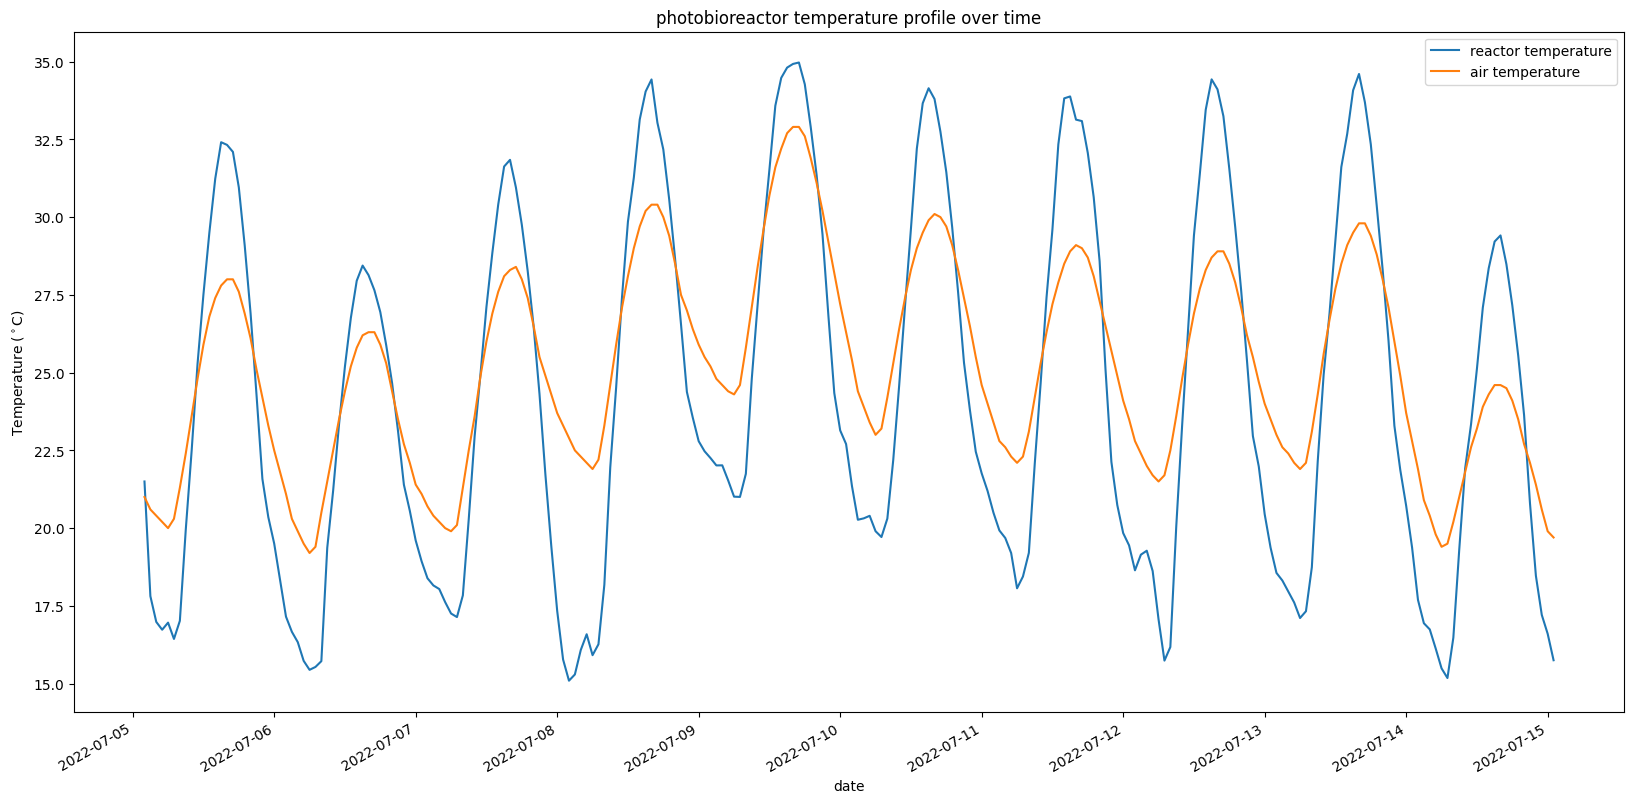

In [405]:
solver = integrate.solve_ivp (heat_bal,(t_span[0],t_span[-1]) ,y0, args = [0.01],t_eval=t_span, method=int_method,max_step=3600)
t_vals = solver.t
y_vals_check = solver.y
y_vals = y_vals_check[0]                #Did this to overcome the problem that the values are stored in a matrix. 
hours = t_span/(time_int*24)
air_temp = data.Ta[hours*24]
t_vals_days = 24/hours
time_values = data.date_time[t_span/time_int]


##          plot results
plt.xlabel('date')
plt.rcParams["figure.figsize"] = (20,10)
plt.ylabel('Temperature ($^\circ$C)')
plt.title('photobioreactor temperature profile over time')
plt.plot(time_values, y_vals-273.15,time_values,air_temp-273.15)
#plt.plot(time_values,y_vals[:-1]-273.15)
plt.gcf().autofmt_xdate()
plt.legend(['reactor temperature','air temperature'])
solver

In [406]:
cooling_energy = {}
heating_energy = {}
def cooled_overview(value,index):
    date_time_value = data.date_time[index]
    date = date_time_value.date()
    if date in cooling_energy:
        cooling_energy[date]+= -value
    else:
        cooling_energy[date]= -value
def heated_overview(value,index):
    date_time_value = data.date_time[index]
    date = date_time_value.date()
    if date in heating_energy:
        heating_energy[date]+= value
    else:
        heating_energy[date]= value

Text(0, 0.5, 'heat flux (W)')

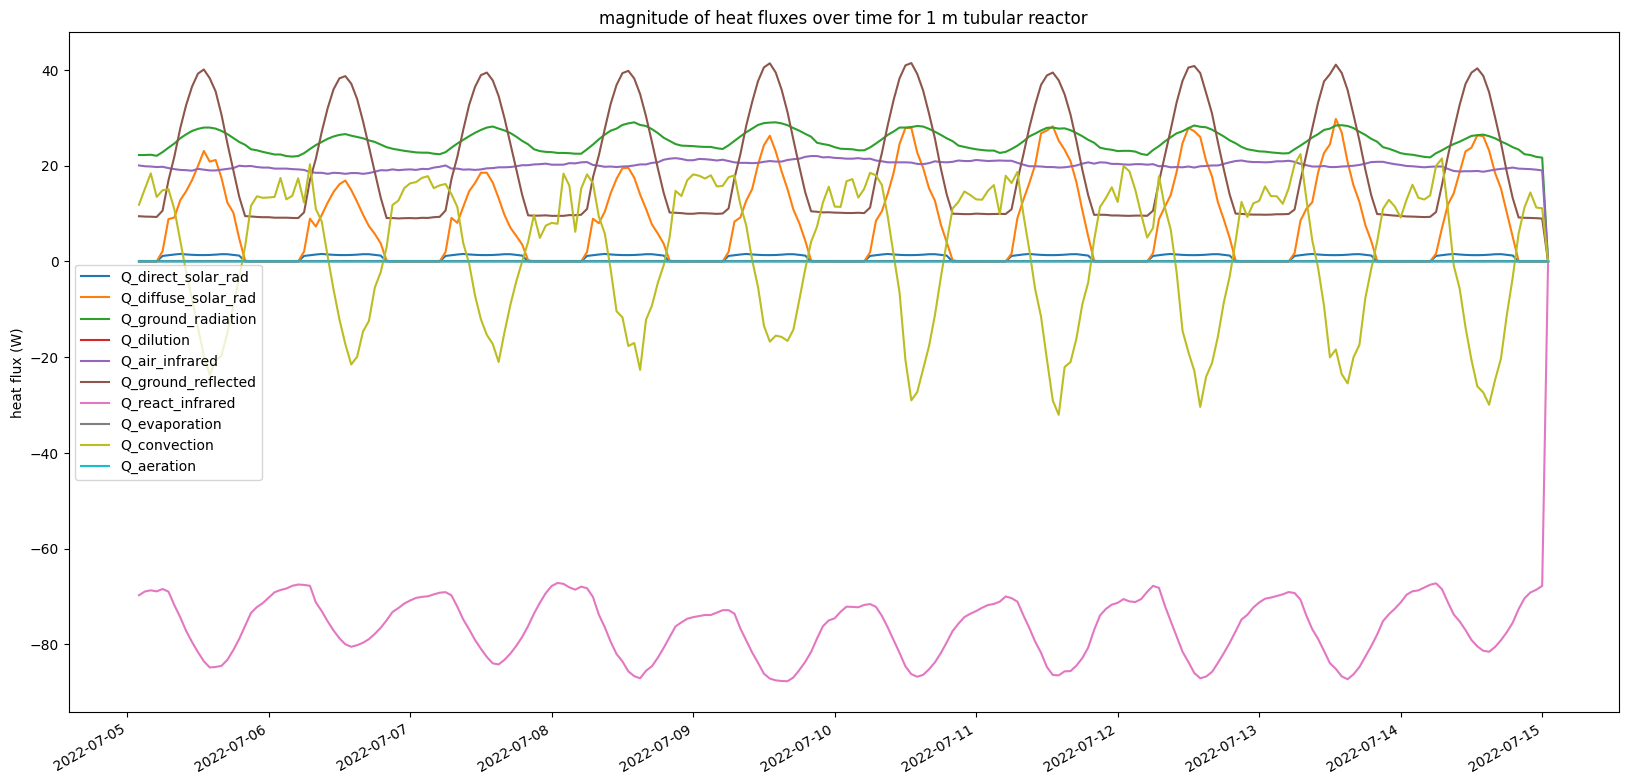

In [407]:
#reverse engineer the heat fluxes, can not extract them directly out of the heat balance function because the integration method
# integration method loops over heat balance multiple times per time step.
cooling_energy = {}
heating_energy = {}
Q_data = np.zeros((len(t_vals)+1,13))
time_index = t_span[0]/3600
general_index = 0
for t in t_vals:
    general_index += 1
    time_index+=1
    try: 
        y = y_vals[general_index]
        Q_direct_solar_rad = direct_solar_rad(t,y,time_index)
        Q_react_infrared = reactor_infrared_radiation(t,y,time_index)
        Q_direct_solar_rad = direct_solar_rad(t,y,time_index)
        Q_diffuse_solar_rad = diffuse_solar_rad(t,y,time_index)
        Q_air_infrared = infrared_rad_air(t,y,time_index)
        Q_dilution  = flow_harvest(t,y,time_index)
        Q_ground_radiation = ground_infrared_radiation(t,y,time_index)
        Q_evaporation = Q_evap(t,y,time_index)
        Q_ground_reflected = ground_reflected_rad(t,y,time_index)
        Q_convection =  convection(t,y,time_index)
        Q_aeration = aeration(t,y,time_index)
        overall = Q_react_infrared+Q_direct_solar_rad+Q_diffuse_solar_rad+Q_air_infrared+Q_dilution+Q_ground_radiation+Q_evaporation+Q_ground_reflected+Q_convection+Q_aeration
        extra_cooled = removed_heat(t,y,time_index,overall)
        extra_heated = added_heat(t,y,time_index,overall)
        cooled_overview(extra_cooled,time_index)
        heated_overview(extra_heated,time_index)
        overall = overall+extra_cooled+extra_heated
    #time_index-=1
        Q_data[general_index] = [Q_direct_solar_rad,Q_diffuse_solar_rad,Q_ground_radiation,Q_dilution,Q_air_infrared,Q_ground_reflected,Q_react_infrared,Q_evaporation,Q_convection,Q_aeration,extra_cooled,extra_heated,overall]
    except:
        pass
    #time_index+=1                       #during the calculation the previous y values are inputted, and the time index is of the next hour, in this way this reverse engineering compensates for that

    
#Q_vals.append([Q_direct_solar_rad,Q_diffuse_solar_rad,Q_ground_radiation,Q_medium_added,Q_air_infrared,Q_ground_reflected,Q_react_infrared,Q_broth_out,Q_evaporation])
Q_data = Q_data[1:]
#columnheader = ['Q_direct_solar_rad','Q_diffuse_solar_rad','Q_ground_radiation','Q_dilution','Q_air_infrared','Q_ground_reflected','Q_react_infrared','Q_evaporation','Q_convection','Q_aeration','extra cooled','extra heated','overall']
columnheader = ['Q_direct_solar_rad','Q_diffuse_solar_rad','Q_ground_radiation','Q_dilution','Q_air_infrared','Q_ground_reflected','Q_react_infrared','Q_evaporation','Q_convection','Q_aeration']
Q_data = Q_data[:,0:10]

Fluxes = pd.DataFrame(Q_data, index= time_values,columns=columnheader)
Fluxes.describe()
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(time_values,Fluxes)
plt.legend(columnheader)
plt.gcf().autofmt_xdate()
plt.title('magnitude of heat fluxes over time for 1 m tubular reactor')
plt.ylabel('heat flux (W)')

,Cooling
Date,
2022-07-05,0.000000
2022-07-06,0.000000
2022-07-07,0.000000
2022-07-08,0.781402
2022-07-09,44.692873
2022-07-10,10.921185
2022-07-11,1.955386
2022-07-12,6.022120
2022-07-13,11.677994


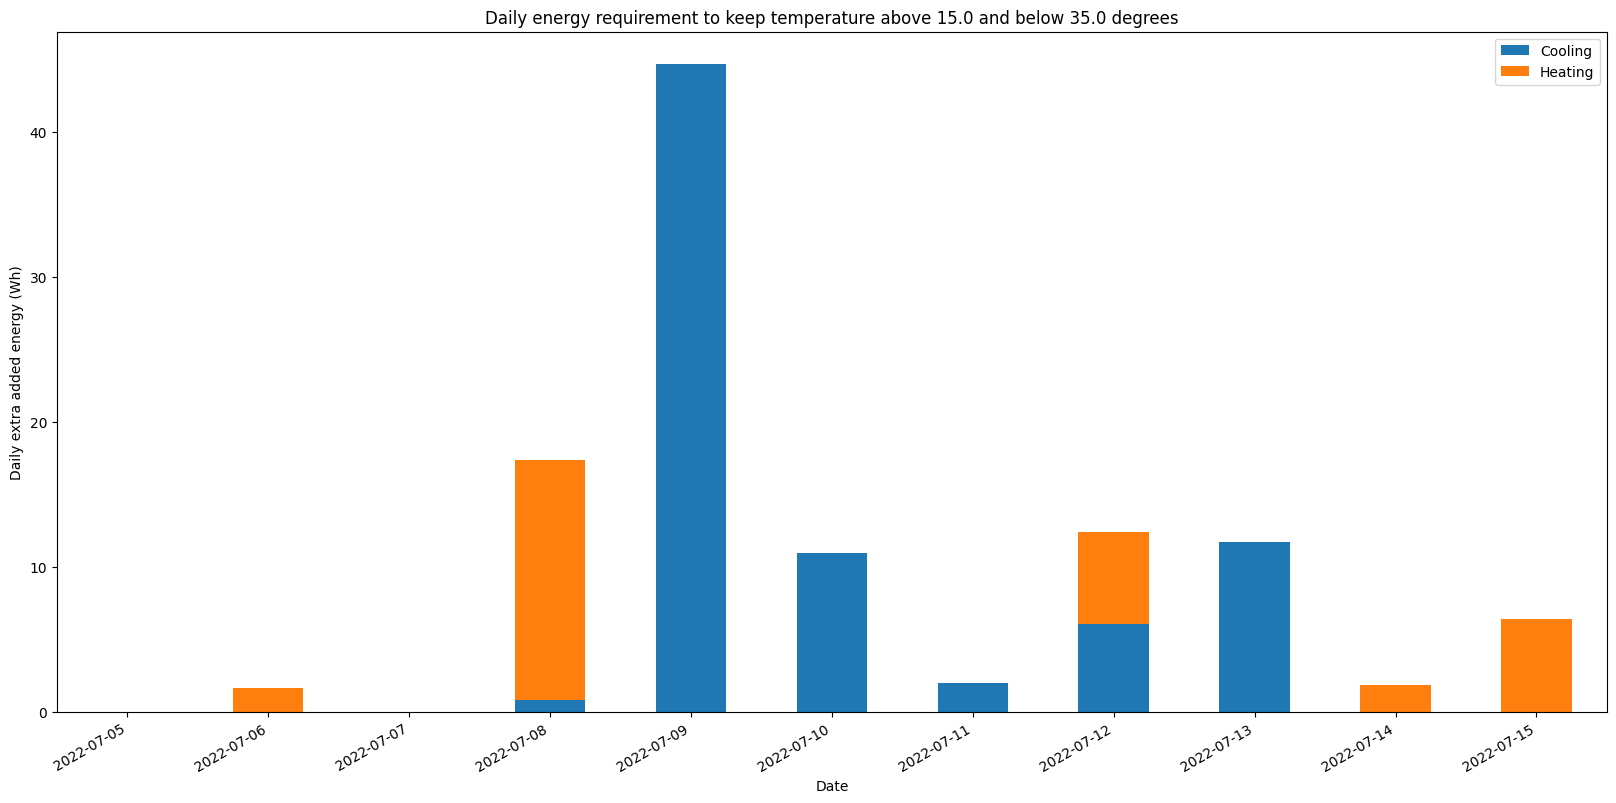

In [408]:
df_cooling = pd.DataFrame({'Date':list(cooling_energy.keys()),'Cooling':list(cooling_energy.values())})
df_heating = pd.DataFrame({'Date':list(heating_energy.keys()),'Heating':list(heating_energy.values())})
df_cooling.set_index('Date',inplace=True)
df_heating.set_index('Date',inplace=True)
df_combined = pd.merge(df_cooling,df_heating,left_index=True,right_index=True,how='outer')
ax = df_combined.plot(kind='bar',stacked=True)
plt.title('Daily energy requirement to keep temperature above '+ str(T_cap_low-273.15)+ ' and below '+ str(T_cap-273.15)+' degrees')
plt.ylabel('Daily extra added energy (Wh)')
plt.gcf().autofmt_xdate()
plt.plot()

#dates = list(cooling_energy.keys())
#dates_heating = list(heating_energy.keys())
values_cooling = list(cooling_energy.values())
values_heating = list(heating_energy.values())

possible_saving = 0
cooling_potential = (T_cap-T_in)*rho_reactor*cp_reactor*V_reactor*0.5/3600
for item in df_cooling.Cooling:
    if item > 0 and item<cooling_potential:
        possible_saving+=item
    elif item>cooling_potential:
        possible_saving+=cooling_potential
    else:
        pass

#plt.bar(dates,values_cooling)
#plt.bar(dates_heating,values_heating,values_cooling)
#plt.title("Daily amount of extra energy required to keep reactor below "+ str(T_cap-273.15)+' degrees')
#plt.xlabel('Day of the year')
#plt.ylabel('Required cooling energy (Wh)')
#plt.ylim(0,500)

total_cooling = sum(values_cooling)/1000
total_heating = sum(values_heating)/1000
total_cooling,total_heating, possible_saving/1000
(T_cap-T_in)*rho_reactor*cp_reactor*V_reactor*0.5/3600
df_cooling